# Алгоритм разбиения бизнесс процесса на подпроцессы по журналу событий основанный на кластеризации трасс
В данном блокноте представлен алгоритм разбиения бизнесс процесса на подпроцессы по журналу событий и его применение 
на журнале событий [BPI Challenge 2017](https://data.4tu.nl/articles/_/12696884/1).

## Оглавление:
1. Подгатовка данных
2. Применение алгоритма
3. Анализ результатов

## Подготовка данных

Для начала подключим необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns

Подгрузим данные. Формат журнала событий ___.xes___ и далее работать с таким форматом будет не очень удобно, поэтому преобразуем его с помощью функций библиотеки pm4py к формату ___.csv___ и сохраним в текущей директории

In [40]:
event_log_xes = pm4py.read_xes("../Data/BPI Challenge 2017.xes")
event_log_csv = pm4py.convert_to_dataframe(event_log_xes)
event_log_csv.to_csv("../Data/BPI Challenge 2017.csv", index=False)

/home/anna/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/home/anna/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:41<00:00, 760.43it/s] 


Теперь уже откроем журнал событий с помощью pandas

In [2]:
df = pd.read_csv("../Data/BPI Challenge 2017/BPI Challenge 2017.csv")


df.head(11)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,statechange,User_1,A_Concept,Application,ApplState_642383566,complete,2016-01-01 09:52:36.413000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Obtained,User_17,W_Complete application,Workflow,Workitem_1875340971,start,2016-01-02 10:45:22.429000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Released,User_17,W_Complete application,Workflow,Workitem_1452291795,suspend,2016-01-02 10:49:28.816000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,statechange,User_52,A_Accepted,Application,ApplState_99568828,complete,2016-01-02 11:23:04.299000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Created,User_52,O_Create Offer,Offer,Offer_148581083,complete,2016-01-02 11:29:03.994000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,NaN


In [13]:
df.shape

(1202267, 21)

In [13]:
df["concept:name"].unique()

array(['A_Create Application', 'A_Submitted', 'W_Handle leads',
       'W_Complete application', 'A_Concept', 'A_Accepted',
       'O_Create Offer', 'O_Created', 'O_Sent (mail and online)',
       'W_Call after offers', 'A_Complete', 'W_Validate application',
       'A_Validating', 'O_Returned', 'W_Call incomplete files',
       'A_Incomplete', 'O_Accepted', 'A_Pending', 'A_Denied', 'O_Refused',
       'O_Cancelled', 'A_Cancelled', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Personal Loan collection',
       'W_Shortened completion '], dtype=object)

Стоит сразу выделить важные атрибуты данного журнала:
- case:concept:name - этот атрибут является по сути case_id - идентификатор каждого отдельного случая. В данном случае это попытка подачи заявки на кредит (случай - ее жизненый цикл одной конкретной заявки)
- concept:name - это атрибут является событием которые происходили с заявкой на протяжении ее жизни (activity)

Закодируем закодируем значения данны аттрубутов

In [3]:
code_case, unique_case = pd.factorize(df["case:concept:name"])
code_activity, unique_activity = pd.factorize(df["concept:name"])

In [5]:
print("Count of cases:", len(unique_case))
print("Count of activities:", len(unique_activity))


Count of cases: 31509
Count of activities: 26


In [4]:
df["code_case"] = code_case
df["code_activity"] = code_activity

In [7]:
grouped_df = df.groupby(df["code_case"])["code_activity"].agg(list).reset_index()

In [40]:
grouped_df["len"] = grouped_df["code_activity"].apply(lambda x : len(x))
grouped_df

,code_case,code_activity,len
0,0,"[0, 1, 2, 2, 3, 4, 3, 3, 5, 6, 7, 8, 3, 9, 9, ...",40
1,1,"[0, 1, 2, 2, 3, 4, 3, 3, 3, 5, 6, 7, 8, 3, 9, ...",31
2,2,"[0, 1, 2, 2, 3, 4, 3, 5, 6, 7, 8, 3, 9, 9, 10,...",45
3,3,"[0, 1, 2, 2, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, ...",84
4,4,"[0, 1, 2, 2, 3, 4, 3, 5, 6, 7, 8, 3, 9, 9, 10,...",21
...,...,...,...
31504,31504,"[0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 3, 9, 9, 10, 9,...",45
31505,31505,"[0, 1, 2, 2, 3, 4, 3, 3, 5, 6, 7, 6, 7, 8, 8, ...",23
31506,31506,"[0, 1, 2, 2, 3, 4, 3, 3, 3, 3, 3, 5, 6, 7, 3, ...",57
31507,31507,"[0, 1, 2, 2, 3, 4, 3, 3, 5, 6, 7, 8, 3, 9, 9, ...",53


In [41]:
for_split = grouped_df[["code_case", "code_activity"]]
for_split

,code_case,code_activity
0,0,"[0, 1, 2, 2, 3, 4, 3, 3, 5, 6, 7, 8, 3, 9, 9, ..."
1,1,"[0, 1, 2, 2, 3, 4, 3, 3, 3, 5, 6, 7, 8, 3, 9, ..."
2,2,"[0, 1, 2, 2, 3, 4, 3, 5, 6, 7, 8, 3, 9, 9, 10,..."
3,3,"[0, 1, 2, 2, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, ..."
4,4,"[0, 1, 2, 2, 3, 4, 3, 5, 6, 7, 8, 3, 9, 9, 10,..."
...,...,...
31504,31504,"[0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 3, 9, 9, 10, 9,..."
31505,31505,"[0, 1, 2, 2, 3, 4, 3, 3, 5, 6, 7, 6, 7, 8, 8, ..."
31506,31506,"[0, 1, 2, 2, 3, 4, 3, 3, 3, 3, 3, 5, 6, 7, 3, ..."
31507,31507,"[0, 1, 2, 2, 3, 4, 3, 3, 5, 6, 7, 8, 3, 9, 9, ..."


In [42]:
grouped_df = grouped_df.drop(["code_case", "code_activity"], axis=1)

In [43]:
grouped_df = grouped_df.rename(columns={'len': 'Length of the trace'})

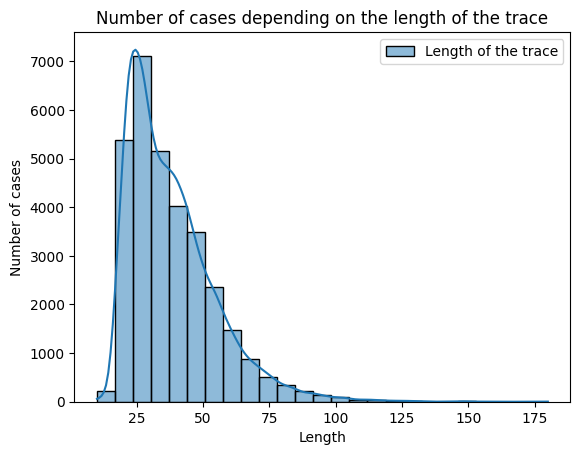

In [44]:

plot = sns.histplot(grouped_df, bins=25, kde=True, color="skyblue")
plt.title("Number of cases depending on the length of the trace")
plt.xlabel("Length")
plt.ylabel("Number of cases")
plt.show()

In [45]:
mean_length = grouped_df["Length of the trace"].mean()
mode_length = grouped_df["Length of the trace"].mode()[0]
print("Средняя длинна слова:", mean_length)
print("Самая часто встречающаяся длинна слова:", mode_length)

Средняя длинна слова: 38.15630454790695
Самая часто встречающаяся длинна слова: 24


## Реализация алгоритма

In [5]:
import LogSplitter

In [6]:
for_activity_df = df.groupby(df["code_case"])["concept:name"].agg(list).reset_index()

In [7]:
corpus = for_activity_df['concept:name'].to_list()

In [8]:
model = LogSplitter.LogSplitter(2)

In [9]:
model.fit(corpus)

In [10]:
model.transform(for_activity_df[["code_case", "concept:name"]],
                 name_id="code_case", name_traces="concept:name")

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 12

In [11]:
model.save_as_csv(df, path="../Data/BPI Challenge 2017/split_event_logs/")

In [12]:
df_0 = pd.read_csv("../Data/BPI Challenge 2017/split_event_logs/0.csv")
df_1 = pd.read_csv("../Data/BPI Challenge 2017/split_event_logs/1.csv")

print(df_0.shape, df_1.shape)

(1201120, 21) (1147, 21)
